# Example time series for architecture diagram

Time series and anomaly scoring for the architecture diagram.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler

from common import generate_intro_example_data
from autotsad.tsad_algorithms.torsk.torsk.timing import start_timer

plt.rcParams["figure.figsize"] = (20, 10)

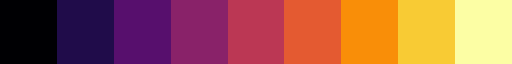

In [2]:
cm = matplotlib.colormaps["inferno"].resampled(9)
cm

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

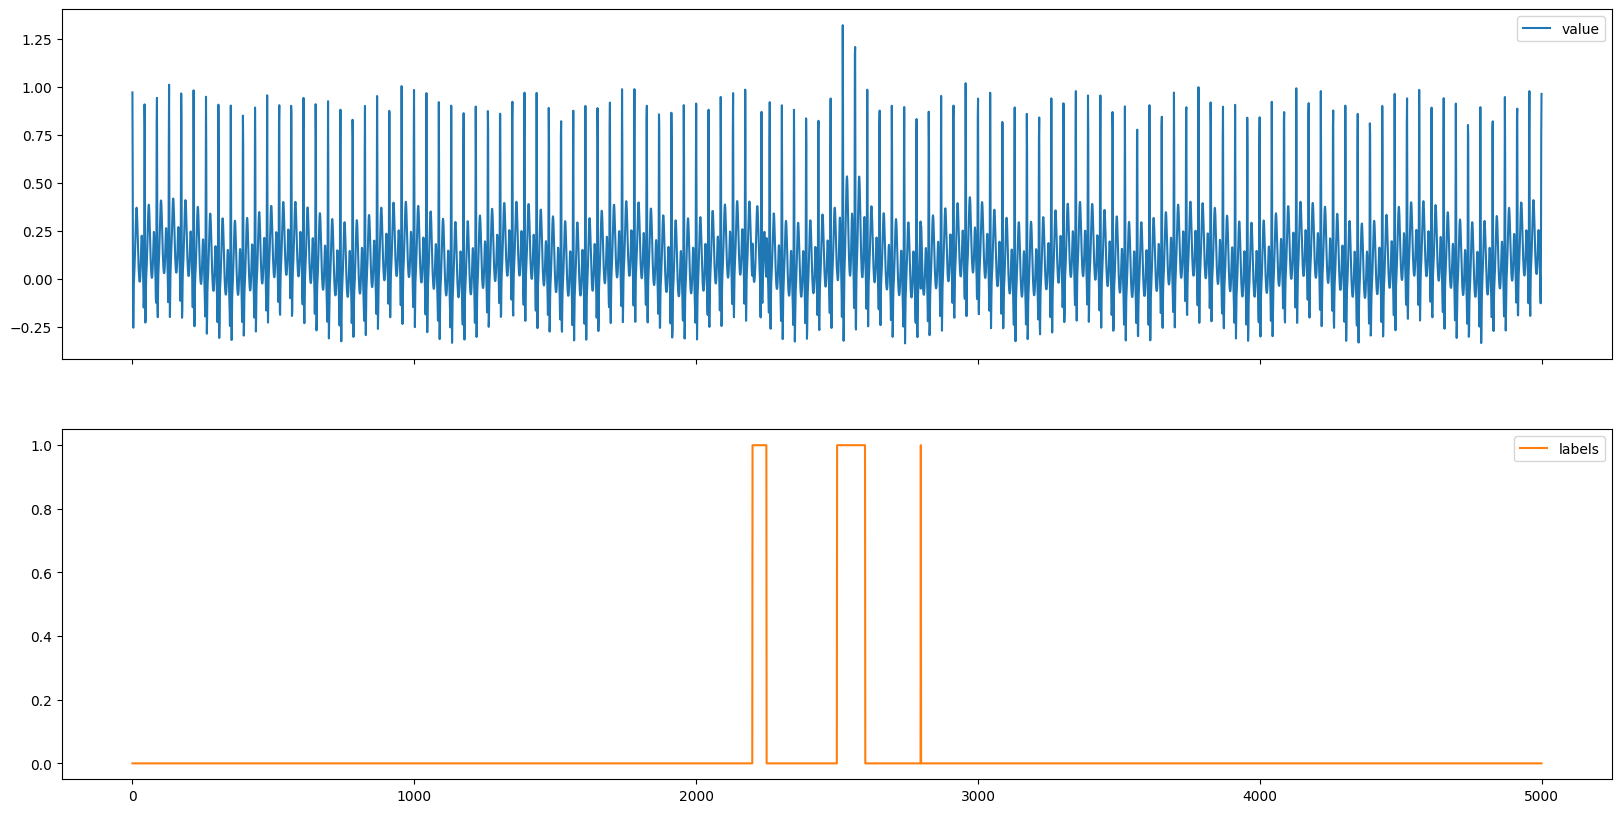

In [3]:
# Create synthetic ECG signal
offset = 2000
df = generate_intro_example_data(anomaly_region_offset=offset)
df[["value", "labels"]].plot(subplots=True)

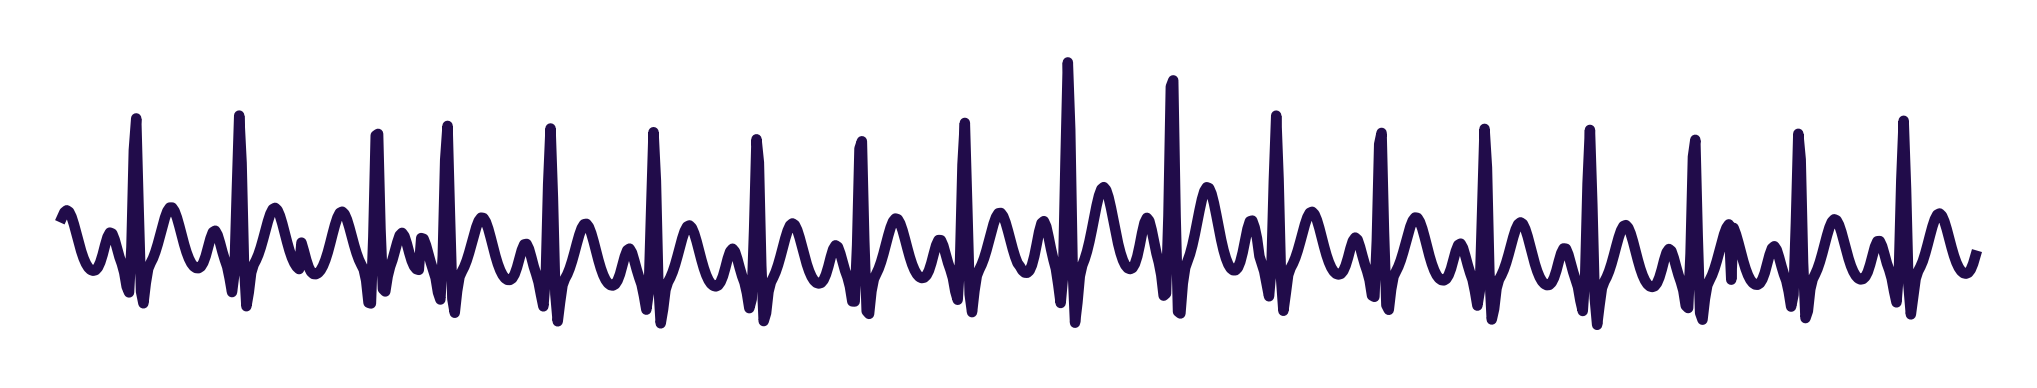

In [4]:
plt.rcParams["font.size"] = 14

show_anomalies = False
anomaly_highlight_color_alpha = 0.6

# anomaly_highlight_color = "red"
# colors = cycle(["orange", "purple", "brown"])
# ts_color = (0.1, 0.1, .5)

# colors = sns.cubehelix_palette(n_colors=6)[0::2]
# ch_colors = sns.cubehelix_palette(start=.25, rot=-.25, light=0.8, dark=0.2, n_colors=6)
# ts_color = ch_colors[4]
# anomaly_highlight_color = sns.cubehelix_palette()[1]

colors = cm.colors[2:-2][::2]
ts_color = cm.colors[1]
anomaly_highlight_color = cm.colors[-2]

start_idx = offset + 100
end_idx = offset + 900

anomalies = []
labels = df["labels"].diff()
for begin, end in zip(labels[labels == 1].index, labels[labels == -1].index):
    anomalies.append((begin, end))

index = df.index[start_idx:end_idx].values
data = df.iloc[start_idx:end_idx, 1].values

fig = plt.figure(figsize=(5, 0.75), dpi=500)
axs = [plt.gca()]
axs[0].plot(index, data, label="Timeseries", color=ts_color)

if show_anomalies:
    # mark anomalies
    y_min = data.min()
    y_max = data.max()
    for begin, end in anomalies:
        width = end - begin
        if width < 2:
            width += 2
            begin -= 1
        axs[0].add_patch(Rectangle((begin, y_min), width, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))

# display styling
axs[0].axis("off")
axs[0].set_xlim(index[0] - 5, index[-1] + 5)

fig.savefig("input.pdf", bbox_inches="tight")
fig.savefig("input.png", bbox_inches="tight")
plt.show()

In [5]:
from autotsad.config import ALGORITHMS
from dataclasses import asdict
from typing import Any, Tuple, Dict
from timeeval import Metric
from autotsad.tsad_algorithms.interop import exec_algo, params_default
import joblib
from pathlib import Path
from timeeval.metrics import RangePrAUC

def execution_job(algorithm: str,
                  data: np.ndarray,
                  label: np.ndarray,
                  metric: Metric,
                  score_dirpath: Path) -> Tuple[str, float]:
    algo_params = params_default(algorithm)
    scores = exec_algo(data, algorithm, algo_params)
    if score_dirpath is not None:
        np.savetxt(str(score_dirpath / f"{algorithm}.csv"), scores, delimiter=",")

    if np.any(label):
        quality = metric(label, scores)
    else:
        quality = -1.
    return algorithm, quality

def execute_algorithms(df: pd.DataFrame, metric: Metric, parallelism: int, score_dirpath: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    score_dirpath = score_dirpath.resolve()
    score_dirpath.mkdir(parents=True, exist_ok=True)
    
    jobs = []
    results = []
    scores = {}
    for a in ALGORITHMS:
        path = score_dirpath / f"{a}.csv"
        if path.exists():
            s = np.genfromtxt(str(path), delimiter=",")
            quality = metric(df["labels"].values, s)
            results.append((a,quality))
            scores[a] = s
        else:
            jobs.append(a)
        
    new_results = joblib.Parallel(n_jobs=min(parallelism, len(ALGORITHMS)))(
        joblib.delayed(execution_job)(
            algorithm, df["value"].values, df["labels"].values, metric, score_dirpath
        )
        for algorithm in jobs
    )
    results.extend(new_results)
    for a, _ in new_results:
        scores[a] = np.genfromtxt(str(score_dirpath / f"{a}.csv"), delimiter=",")
    return pd.DataFrame(results, columns=["algorithm", "quality"]), pd.DataFrame(scores)

# create dummy anomaly scorings
results_path = Path("scores")
df_results, df_scores = execute_algorithms(df, metric=RangePrAUC(buffer_size=100), parallelism=-1, score_dirpath=results_path)
df_scores[df_scores.columns] = MinMaxScaler().fit_transform(df_scores.values)

df_results = df_results.sort_values("quality", ascending=False)
df_scores = df_scores[df_results["algorithm"].tolist()]
df_scores

,stomp,subsequence_knn,subsequence_if,subsequence_lof,kmeans,grammarviz,dwt_mlead,torsk
0,0.007595,0.100943,0.213112,0.018011,0.021049,0.197166,0.0,0.000000
1,0.013048,0.101078,0.073467,0.019726,0.352768,0.197166,0.0,0.000000
2,0.017235,0.100122,0.093843,0.020013,0.221536,0.197166,0.0,0.000000
3,0.013168,0.097096,0.113985,0.019471,0.182370,0.197166,0.0,0.000000
4,0.010700,0.095937,0.103113,0.019303,0.194082,0.197166,0.0,0.000000
...,...,...,...,...,...,...,...,...
4995,0.008675,0.073891,0.018197,0.011958,0.267766,0.153800,1.0,0.343936
4996,0.008967,0.075439,0.024498,0.012780,0.263866,0.153800,1.0,0.327086
4997,0.008679,0.077125,0.030307,0.014188,0.284902,0.153800,1.0,0.395021
4998,0.008935,0.080235,0.068070,0.017060,0.376706,0.153800,1.0,0.592532


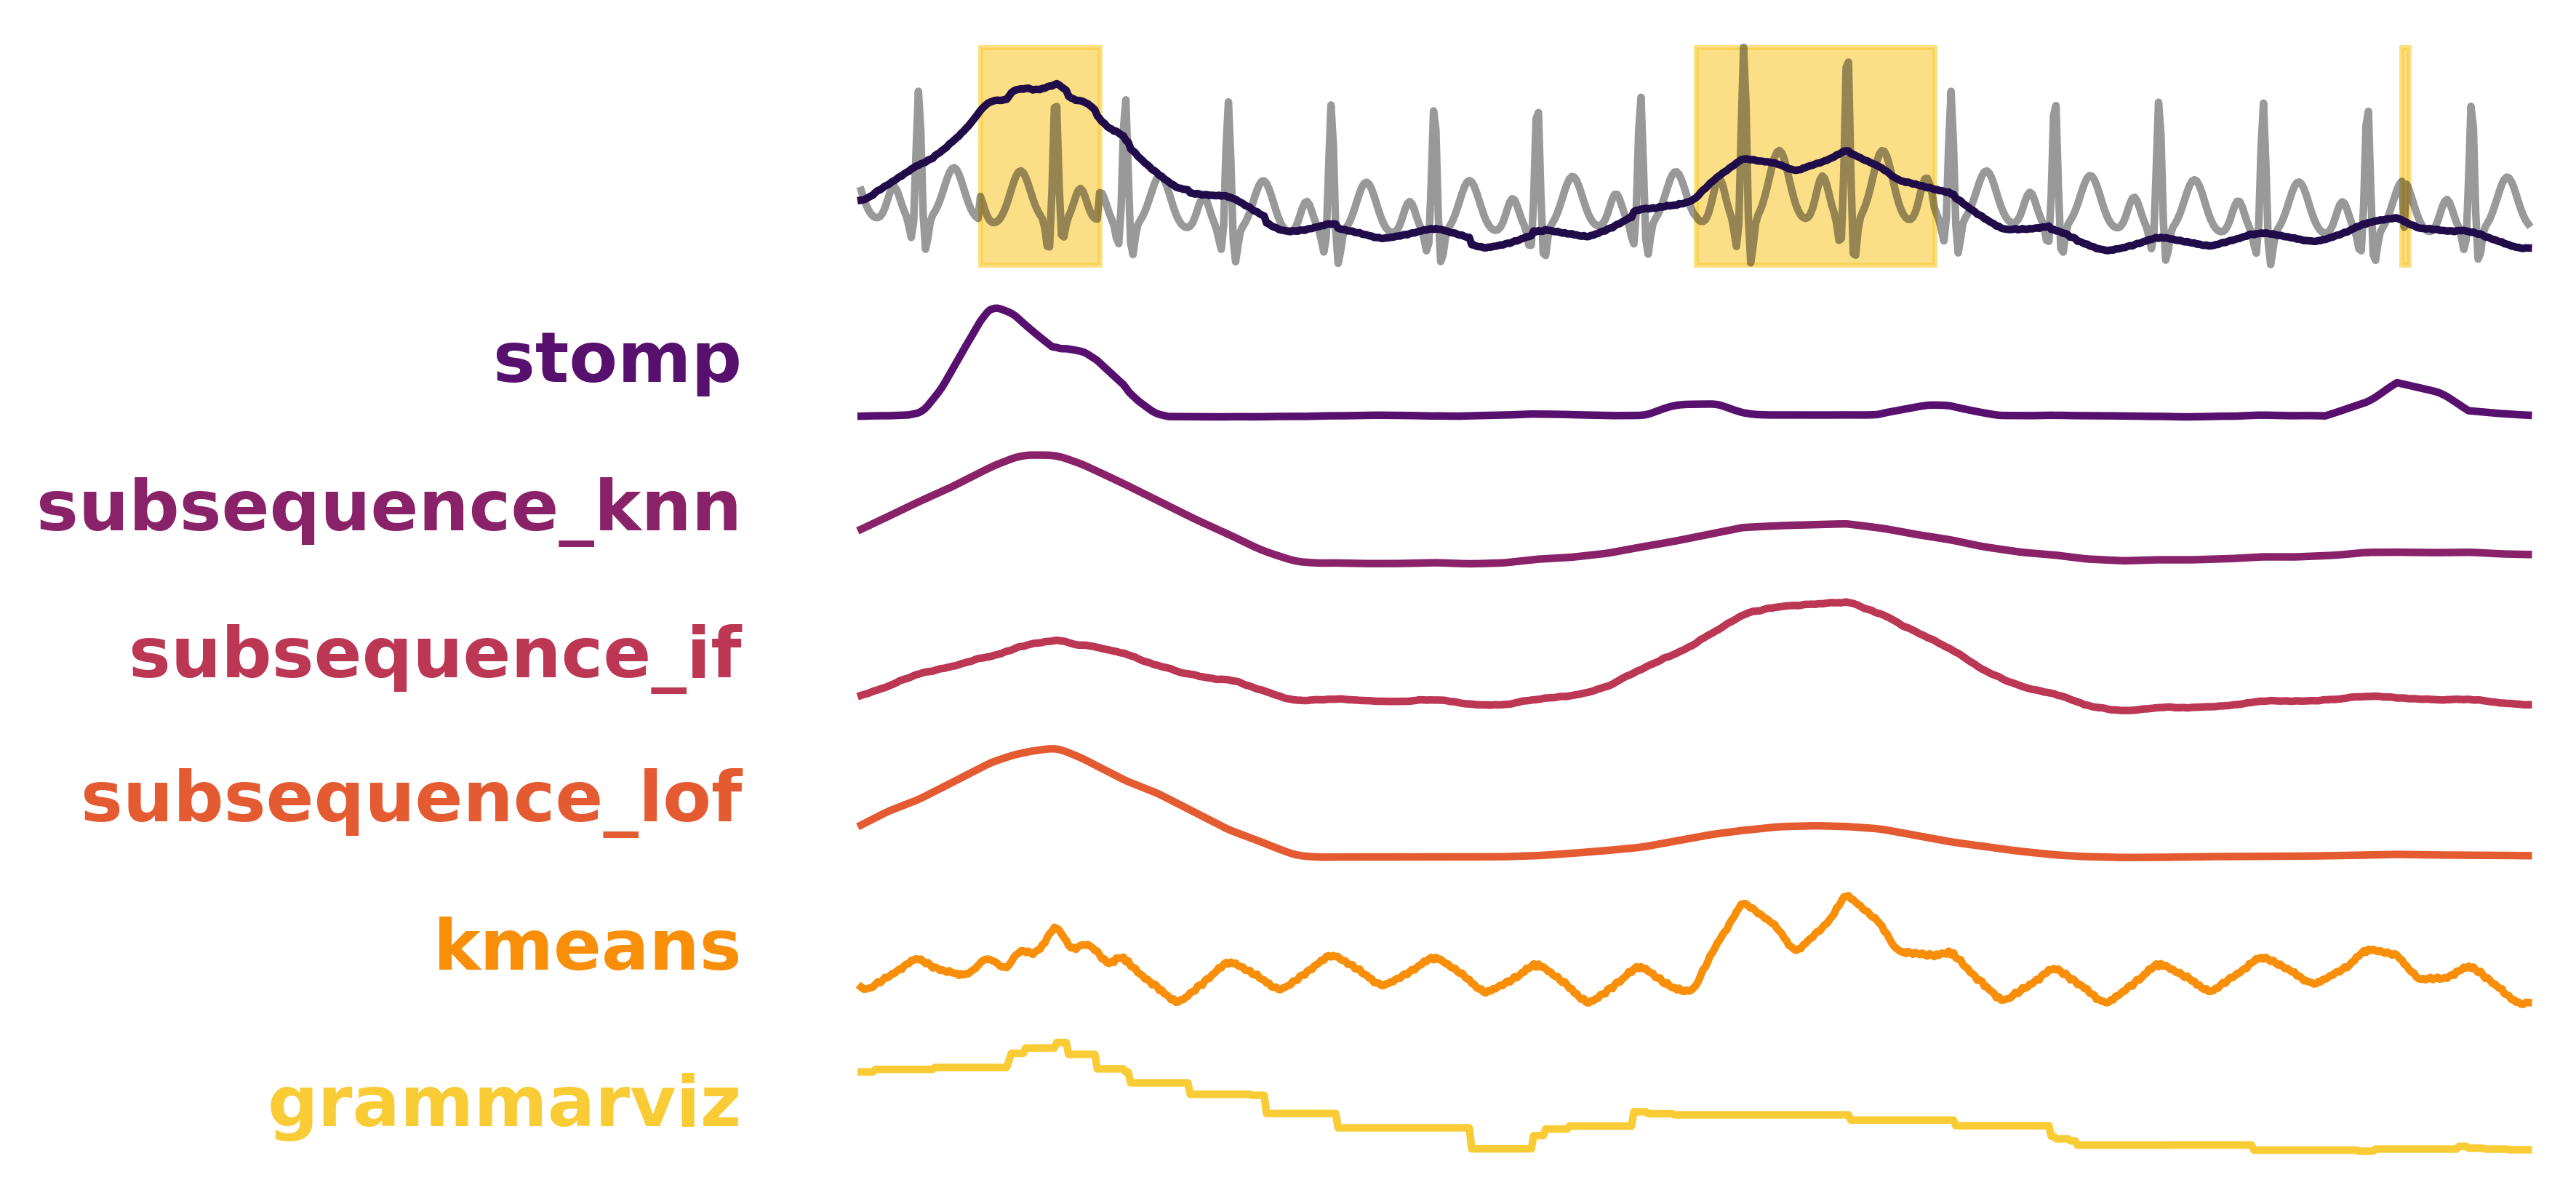

In [6]:
from autotsad.system.execution.aggregation import aggregate_scores

# config
max_instances = 6
show_anomalies = True
show_algo_quality = False

colors = cm.colors[2:-1]
ts_color = cm.colors[0]
combined_score_color = cm.colors[1]
anomaly_highlight_color = cm.colors[-2]
anomaly_highlight_color_alpha = 0.6

start_idx = offset + 150
end_idx = offset + 850

# prepare data
results = df_results.iloc[:max_instances, :]
index = df.index[start_idx:end_idx].values
data = df.iloc[start_idx:end_idx, 1].values
data = MinMaxScaler().fit_transform(data.reshape(-1, 1)).ravel()
combined_score = aggregate_scores(df_scores[results["algorithm"].tolist()].values, agg_method="mean")

anomalies = []
labels = df["labels"].diff()
for begin, end in zip(labels[labels == 1].index, labels[labels == -1].index):
    anomalies.append((begin, end))

# plot
fig, axs = plt.subplots(1 + len(results), 1, sharex="col", figsize=(6, 4), dpi=500,
                        gridspec_kw={"height_ratios": [2, *[1 for _ in range(results.shape[0])]]})
axs[0].plot(index, data, color=ts_color, alpha=0.4, label="Timeseries")

if show_anomalies:
    # mark anomalies
    y_min = data.min()
    y_max = data.max()
    for begin, end in anomalies:
        width = end - begin
        if width < 2:
            width += 2
            begin -= 1
        axs[0].add_patch(Rectangle((begin, y_min), width, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))

# display styling
axs[0].axis("off")
axs[0].set_xlim(index[0] - 5, index[-1] + 5)

# reset index to allow loc-indexing
results = results.reset_index(drop=True)
for i, c in zip(range(1, len(results) + 1), colors):
    algo, quality = results.loc[i-1, ["algorithm", "quality"]]
    if show_algo_quality:
        label = f"{algo} ({quality:.0%})"
    else:
        label = algo

    axs[i].plot(index, df_scores[algo].values[start_idx:end_idx], label=label, color=c)
    axs[i].axis("off")
    axs[i].text(start_idx-50, 0.5, algo, ha="right", va="center", color=c, fontsize=14, fontweight="bold")

axs[0].plot(index, combined_score[start_idx:end_idx], label="Combined score", color=combined_score_color)

# create legend
# lines, labels = [], []
# for i in range(axs.shape[0]):
#     li2, la2 = axs[i].get_legend_handles_labels()
#     lines.extend(li2)
#     labels.extend(la2)
# legend = fig.legend(
#     lines, labels,
#     loc="center",
#     ncol=2,
#     bbox_to_anchor=(0.5, 1.1),
#     borderaxespad=0.,
# )

fig.savefig("output-ranking.pdf", bbox_inches="tight")
fig.savefig("output-ranking.png", bbox_inches="tight")
plt.show()

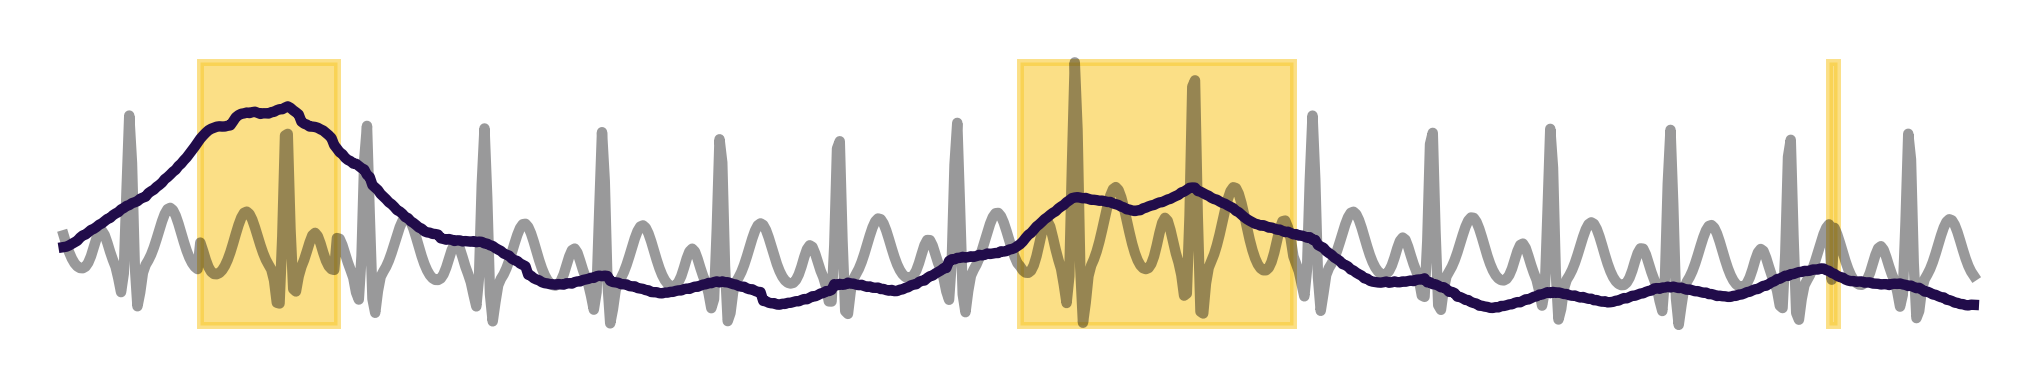

In [7]:
# plot single combined ranking
fig = plt.figure(figsize=(5, 0.75), dpi=500)
ax = plt.gca()
ax.plot(index, data, color=ts_color, alpha=0.4, label="Timeseries")

if show_anomalies:
    # mark anomalies
    y_min = data.min()
    y_max = data.max()
    for begin, end in anomalies:
        width = end - begin
        if width < 2:
            width += 2
            begin -= 1
        ax.add_patch(Rectangle((begin, y_min), width, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))

# display styling
ax.axis("off")
ax.set_xlim(index[0] - 5, index[-1] + 5)
ax.plot(index, combined_score[start_idx:end_idx], label="Combined score", color=combined_score_color)

fig.savefig("output.pdf", bbox_inches="tight")
fig.savefig("output.png", bbox_inches="tight")
plt.show()